## Notebook for modeling G-protein activated current and changes in membrane potential

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np 
import matplotlib.pylab as plt

In [339]:
from scipy.integrate import odeint

class Params:
    def __init__(self):
        self.Vmax = 1.
        self.toggleGprot = False
        self.tOnGprot = 5.      
        self.Vm0 = -20.09 # resting potential[mV]
        self.INKA = -1.  # pA
        self.Cm = 1. # pF
        self.tOnCaLig=20.
        self.toggleCaLig=False 
        self.ca0 = 0.1  # uM
params = Params()        

### Major channels, etc, for the system

In [442]:
def NKA(Vm,params):
    Vmax = 25.   # put into params
    Vm50 = 0.5 # mV
    JSERCA = -Vmax/(1 + (Vm50/Vm)**2)
    return JSERCA
    

def iKChannel(rhoKchannel,Vm, E,Gprot, params):
    gCond = 5.
    vDiff = Vm - E
    IV = Vm+90  # very crude approx for IV 
    if IV>10: IV = 10
    KDGprot = 1.
    iKChannel = gCond * vDiff * rhoKchannel * 1/(1 + KDGprot/Gprot)
    return iKChannel

def caOut(Ca,params):
    g = -(0.1 + (Ca-params.ca0)*750./(1 + (1/Ca)**6))
    return g


def iCaChannel(Vm,CaLig, params):
    gCond = 0.25
    E = 0.
    vDiff = Vm - E
    KDCaLig = 1.
    iCaChannel = gCond * vDiff * 1/(1 + KDCaLig/CaLig)
    return iCaChannel

def iLeak(Vm,params):
    g = np.exp((Vm-params.Vm0)/10.)
    if g>1.: g=1.
    g *= -params.INKA
    
    return g

# simulates adding a ligand
def ligand(t,tOn,toggle=False):
      scale = 0.  
      if toggle:
        if (t > tOn):
            scale=np.exp(-(t-tOn))
      if (t<tOn or t>=(tOn+99999)):
        scale=0.
      return scale

In [429]:
def PlotData(data):
    fig,ax = plt.subplots(1)
    key = 'Vm'
    ax.plot(data['ts'],data[key],label=key)
    ax.set_ylabel("V [mV]")
    ax.set_xlabel("[s]")
    plt.legend(loc=0)

    axR = plt.twinx(ax)
    key = 'Gprots'
    axR.plot(data['ts'],data[key],'k--',label=key)  
    axR.set_ylabel("Gprot")
    
    plt.figure()
    fig,ax = plt.subplots(1)
    key = 'Ca'
    ax.plot(data['ts'],data[key],label=key)
    ax.set_ylabel("Ca [uM]")
    ax.set_xlabel("[s]")
    plt.legend(loc=0)

    axR = plt.twinx(ax)
    key = 'CaLig'
    axR.plot(data['ts'],data[key],'k--',label=key)  
    axR.set_ylabel("CaLig [uM]")    

### Model 
includes
- G-protein generation
- G protein-dependent activation of K channel
- regulation of membrane potential 
- Ca channel activation 

In [443]:

def dydt(y,t,params):
    P2Y12=0
    Vm, rhoKchannel,Gprot,CaLig,Ca = y
    
    # currents, including G-protein dependent K channel activation 
    IK = iKChannel(rhoKchannel,Vm, Ek,Gprot,params)
    ICa = iCaChannel(Vm,CaLig,params)
    ILeak = iLeak(Vm,params)
    INKA = params.INKA;
    
    # Membrane potential 
    dVm_dt = -(IK + ILeak +  INKA+ ICa)/params.Cm;
  
    # K channel density 
    kgK = 1.
    kdK = 1.
    drhoKchannel_dt = kgK - kdK*rhoKchannel
    
    # Ca channel ligand 
    kgCaLig = 1.
    kdCaLig = 10.
    rGen= ligand(t,params.tOnCaLig,params.toggleCaLig)  
    dCaLig_dt = rGen - kdCaLig * CaLig
    
    # Ca conc.
    dCa_dt= -ICa # UNITs!!!!
    caLeak = 0.1
    dCa_dt+= caOut(Ca,params) + caLeak
    
    # g protein 
    kgG = 1.
    kdG = 10.
    rGen= ligand(t,params.tOnGprot,params.toggleGprot)  
    dGprot_dt = rGen - kdG * Gprot
    
    # return 
    dydt = [dVm_dt, drhoKchannel_dt, dGprot_dt,dCaLig_dt,dCa_dt]
    return dydt
   
    
def Ksim(
    Gprot = 1e-2,# [uM],
    ligand =1e-2,# [uM]
    tEnd = 100,
    params = Params()
  ):
    Vm = params.Vm0
    rhoKchannel = 1.  # 
    kCyto0=150e3 # uM  # going to assume these concs. don't change much 
    kExo0 = 2e3  # uM 
    CaLig=1e-3
    Ca = params.ca0 # +.2 # [uM]
    ts = np.linspace(0,tEnd,1000)


    RT = 22.0 # quick guess [mV]
    Ek = -RT * np.log(kCyto0/kExo0)
    y0 = [Vm, rhoKchannel,Gprot,CaLig,Ca]

     
    ys = odeint(dydt,y0,ts,args=(params,))
    
    data = {}
    data['ts']=ts
    data['Vm'] = ys[:,0]
    data['rhoKchannels'] = ys[:,1]
    data['Gprots'] = ys[:,2]
    data['CaLig'] = ys[:,3]
    data['Ca'] = ys[:,4]
    
    return data

#### Basal conditions 
Steady state expected for system 

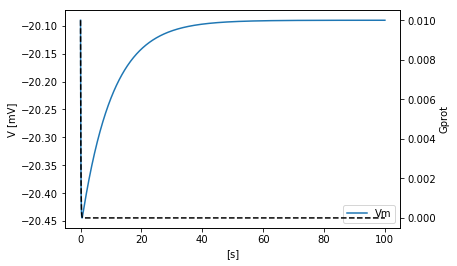

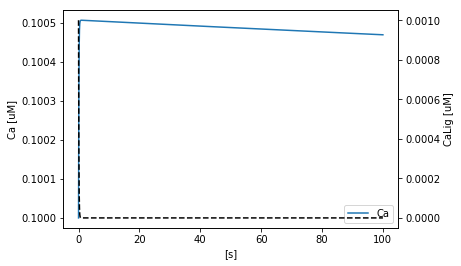

In [444]:
params = Params()
data = Ksim(tEnd=100,params=params)
PlotData(data)


#### G protein content spiked, triggers K channel activation and change in membrane potential that relaxes back to steady state 

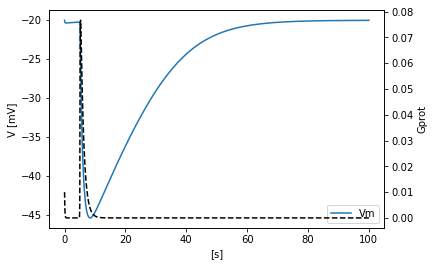

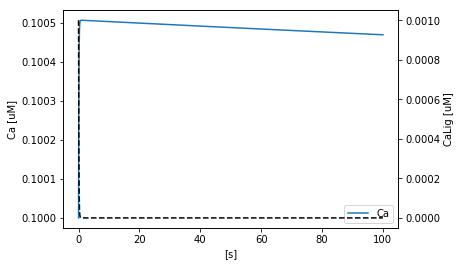

In [445]:
params = Params()
params.toggleGprot = True
data = Ksim(params=params)
PlotData(data)

#### Ligand-dependent activation of Ca channel.
Membrane potential should relax back to Vm0, but haven't implemented mechanisms for which
We report max Ca

0.320526155183


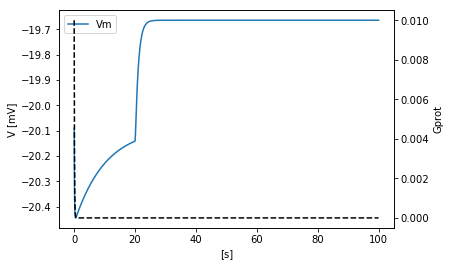

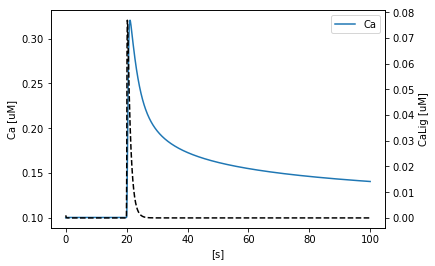

In [446]:
params = Params()
params.toggleGprot = False
params.toggleCaLig = True
data = Ksim(params=params)
PlotData(data)

print np.max( data['Ca']  )

#### K channel fires (leading to much lower membrane potential), followed by Ca channel activation
We also report Max Ca here, which is higher because of the greater electromotice force 

0.363653775732


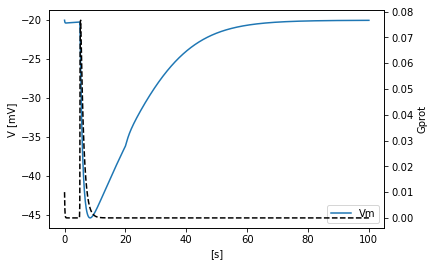

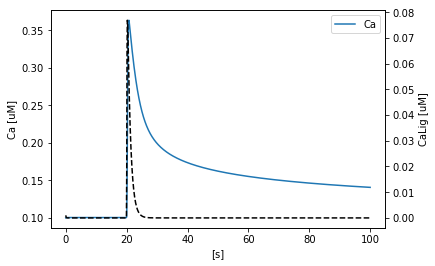

In [448]:

params = Params()
params.toggleGprot = True
params.toggleCaLig = True
data = Ksim(params=params)
PlotData(data)


print np.max( data['Ca']  )